# Introduction: Exploring Wikipedia Book Data

After gathering all of the data about books on Wikipedia, it's time to see what we can find from it! In this notebook we'll explore the data in preparation for creating a recommendation engine based on embeddings.

## Read in Data

In [1]:
import pandas as pd
import numpy as np

import json

In [3]:
data_path = 'found_books.ndjson'

books = []

with open(data_path, 'r') as fin:
    for l in fin.readlines():
        books.append(json.loads(l))
        
print(f'Found {len(books)} books.')

Found 37861 books.


In [5]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
import pprint

books[2]

['The Buried Pyramid',
 {'author': 'Jane Lindskold', 'publisher': 'Tom Doherty Associates'},
 ['Jane Lindskold',
  'Jane Lindskold',
  'Tom Doherty Associates',
  'Albert, Prince Consort',
  'Moses',
  'Anubis',
  'Category:2004 American novels',
  'Category:Novels set in Egypt'],
 [],
 '2017-08-17T19:10:05Z']

# Internal Links

First we'll explore the distribution of internal wikilinks. These are links within articles that point to other Wikipedia articles. We collected the titles of every one of these links for each book.

In [29]:
wikilinks = [book[2] for book in books]
wikilinks[2]

['Jane Lindskold',
 'Jane Lindskold',
 'Tom Doherty Associates',
 'Albert, Prince Consort',
 'Moses',
 'Anubis',
 'Category:2004 American novels',
 'Category:Novels set in Egypt']

This is currently a list of lists. We can count the number of wikilinks each book has using the following code.

In [30]:
wikilink_count = [len(x) for x in wikilinks]

Let's make a dataframe so we can keep track of the information for each book.

In [32]:
data = pd.DataFrame({'title': [book[0] for book in books], 'wikilink_count': wikilink_count})
data.sort_values('wikilink_count').tail()

,title,wikilink_count
2258,Wikipedia:Village pump (technical)/Archive 125,3177
27877,Wikipedia:Administrators' noticeboard/Archive281,3192
10913,Wikipedia:Village pump (technical)/Archive 139,3286
14509,Wikipedia:Administrators' noticeboard/Archive246,3680
3437,Wikipedia:Articles for creation/Redirects/2012-10,3926


This looks like we have some anomalies! We have inadvertently captured articles that clearly are not books, but do mention the `Infobox book` template. Let's see how many of these there are.

In [36]:
potential_anomlies = [book[0] for book in books if 'Wikipedia' in book[0]]
len(potential_anomlies)

129

We'll remove all of these articles.

In [37]:
books = [book for book in books if 'Wikipedia' not in book[0]]
len(books)

37732

In [39]:
wikilinks = [book[2] for book in books]
wikilink_count = [len(x) for x in wikilinks]

pd.options.display.max_colwidth = 100

data = pd.DataFrame({'title': [book[0] for book in books], 'wikilink_count': wikilink_count})
data.sort_values('wikilink_count').tail()

,title,wikilink_count
36132,Biographical Dictionary of the Extreme Right Since 1890,963
23052,Andrew Lang's Fairy Books,1024
16959,1001 Video Games You Must Play Before You Die,1043
5886,Timeline of science fiction,1398
12044,Asimov's Biographical Encyclopedia of Science and Technology,1765


It still seems like there are a few anomalies. However, to remove these further, we'd have to go through one at a time and inspect the pages. For now, we can simply leave these in and hope they don't have too great of an impact on the analysis.

In [40]:
from itertools import chain

print(f"There are {len(set(chain(*wikilinks)))} unique wikilinks.")

There are 319895 unique wikilinks.


We can also count the occurence of each Wikilink. This makes use of the `Counter` class in the collections library.

In [42]:
from collections import Counter

wikilink_counts = Counter(chain(*wikilinks))
wikilink_counts['War and Peace']

28

In [43]:
wikilink_counts = sorted(wikilink_counts.items(), key = lambda x: x[1], reverse = True)
wikilink_counts[:10]

[('Hardcover', 7682),
 ('Paperback', 7546),
 ('Wikipedia:WikiProject Books', 6121),
 ('Wikipedia:WikiProject Novels', 6093),
 ('English language', 4365),
 ('The New York Times', 4046),
 ('United States', 3468),
 ('Science fiction', 3185),
 ('science fiction', 2734),
 ('Publishers Weekly', 2525)]

The top wikilinks make a lot of sense. We can search through the wikilink counts for only those books to see what are the most linked to books by other books.

First we'll make a dictionary for mapping books to an index.

In [44]:
book_to_idx = {book[0]: idx for idx, book in enumerate(books)}
len(book_to_idx)

37732

In [45]:
wikilink_books = [x for x in wikilink_counts if x[0] in book_to_idx.keys()]
wikilink_books[:10]

[('The Discontinuity Guide', 149),
 ('The Encyclopedia of Science Fiction', 148),
 ('The Lord of the Rings', 132),
 ('Discworld', 129),
 ('Harry Potter', 114),
 ('Redwall', 109),
 ('Barsoom', 94),
 ('Animorphs', 93),
 ('Eighth Doctor Adventures', 86),
 ('Lone Wolf (gamebooks)', 77)]

These aren't that surprising, although the top links appear to be mostly books series.

## External Links

In [102]:
ex_links = [book[3] for book in books]
len(set(chain(*ex_links)))

169339

In [109]:
ex_link_counts = sorted(Counter(chain(*ex_links)).items(), key = lambda x: x[1], reverse = True)
ex_link_counts[:10]

[('https://www.ebsco.com', 878),
 ('http://search.ebscohost.com/login.aspx?direct=true', 286),
 ('http://guide.doctorwhonews.net/info.php?detail=ratings', 150),
 ('http://darwin-online.org.uk/content/frameset?viewtype=text', 98),
 ('https://books.google.com/books?hl=en', 94),
 ('http://en.wikipedia.org/wiki/Wikipedia:Footnotes', 86),
 ('http://www.litencyc.com/php/sworks.php?rec=true', 77),
 ('http://docs.newsbank.com/openurl?ctx_ver=z39.88-2004', 73),
 ('https://en.wikipedia.org/wiki/WP:REFB', 69),
 ('http://www.nea.org/grants/13154.htm/', 63)]

# Exploring Categories

Many of the external links refer to categories. We can count the number of different categories and take a look at the options.

In [6]:
categories = []

for book in books:
    for link in book[2]:
        if 'Category:' in link:
            categories.append(link[9:])
    
print(f"There are {len(set(categories))} unique categories.")

There are 25492 unique categories.


In [7]:
from collections import Counter

cate_counts = dict(Counter(categories))
cate_count_list = sorted(cate_counts.items(), key = lambda x: x[1], reverse = True)
cate_count_list[:10]

[('American science fiction novels', 1302),
 ('American novels adapted into films', 1144),
 ('Debut novels', 1076),
 ('American fantasy novels', 1052),
 ('American young adult novels', 996),
 ('HarperCollins books', 918),
 ('British novels adapted into films', 857),
 ('English-language books', 774),
 ("American children's novels", 647),
 ('American non-fiction books', 635)]

What are the most rare categories? 

In [8]:
cate_count_list[-10:]

[('Lobotomised people', 1),
 ('Sexual revolution', 1),
 ('Books of Christian biography', 1),
 ('Books by Elisabeth Elliot', 1),
 ('Dutchess County, New York', 1),
 ('Earp family', 1),
 ('Ice skating', 1),
 ('Melanesia', 1),
 ('Adoption in the United States', 1),
 ('1975 television films', 1)]

(array([2.5334e+04, 1.0700e+02, 2.8000e+01, 1.1000e+01, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3110e+02, 2.6120e+02, 3.9130e+02, 5.2140e+02,
        6.5150e+02, 7.8160e+02, 9.1170e+02, 1.0418e+03, 1.1719e+03,
        1.3020e+03]),
 <a list of 10 Patch objects>)

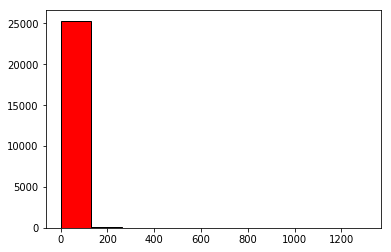

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([x[1] for x in cate_count_list], color = 'red', edgecolor = 'k')

In [10]:
def ecdf(x):
    x = np.sort(x)
    n = len(x)
    y = np.arange(1, n + 1, 1) / n
    return x, y

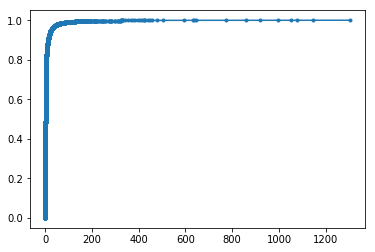

In [11]:
xs, ys = ecdf([x[1] for x in cate_count_list])
plt.plot(xs, ys, marker = '.')

# Exploring Book Attributes

We can also look through all the information that was in the infobox templates. We'll collect this into a single dictionary.

In [12]:
attributes = {}

for book in books:
    for key, value in book[1].items():
        if key in attributes:
            attributes[key].append(value)
        else:
            attributes[key] = [value]

print(f'There are a total of {len(attributes)} attributes.')

There are a total of 231 attributes.


In [13]:
attributes.keys()

dict_keys(['name', 'image', 'caption', 'author', 'country', 'language', 'published', 'publisher', 'publisher2', 'subject', 'genre', 'release_date', 'media_type', 'pages', 'isbn', 'series', 'preceded_by', 'followed_by', 'title_orig', 'translator', '1', 'subjects', 'pub_date', 'cover_artist', 'isbn_note', 'oclc', 'illustrator', 'english_pub_date', 'number_of_books', 'preceded by', 'followed by', 'italic title', 'congress', 'border', 'awards', 'dewey', 'image_caption', 'image_size', 'exclude_cover', 'english_release_date', 'ISBN', 'alt', 'set_in', 'books', 'translators', 'orig_lang_code', 'website', 'notes', 'audio_read_by', 'authors', 'width', 'release_number', 'infoboxwidth', 'editor', 'award', 'discipline', 'editors', 'external_url', 'external_host', 'native_external_url', 'native_external_host', 'wikisource', '2', 'native_wikisource', 'list_books', 'genres', 'ISBN_note', 'hidden', 'tracking', 'description', 'dedicated_to', 'size', 'title_working', 'Article', 'Description', 'Source', '

In [23]:
num_attr = {key: len(values) for key, values in attributes.items()}
num_attr = sorted(num_attr.items(), key = lambda x: x[1], reverse = True)
num_attr[:30]

[('name', 37075),
 ('author', 36195),
 ('language', 33487),
 ('country', 31284),
 ('publisher', 31176),
 ('image', 29254),
 ('genre', 26545),
 ('media_type', 26438),
 ('pages', 26094),
 ('isbn', 24936),
 ('release_date', 20451),
 ('caption', 19423),
 ('1', 14945),
 ('oclc', 13916),
 ('followed_by', 11662),
 ('pub_date', 11096),
 ('preceded_by', 10717),
 ('series', 8905),
 ('cover_artist', 7162),
 ('congress', 6894),
 ('subject', 6721),
 ('dewey', 5456),
 ('published', 4442),
 ('title_orig', 3668),
 ('isbn_note', 3467),
 ('illustrator', 3322),
 ('image_size', 2958),
 ('italic title', 2070),
 ('translator', 1951),
 ('english_pub_date', 1254)]

Let's make a dataframe that has the columns as the attributes and each row is a book. We'll keep only the 100 most common attributes.

In [24]:
num_attr_top = num_attr[:30]

data = pd.DataFrame(columns = ['title'] + [x[0] for x in num_attr_top])
data['title'] = [x[0] for x in books]
data.head()

,title,name,author,language,country,publisher,image,genre,media_type,pages,...,subject,dewey,published,title_orig,isbn_note,illustrator,image_size,italic title,translator,english_pub_date
0,Can't Anybody Here Play This Game?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summa Iniuria: Ein Pitaval der Justizirrtümer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,The Buried Pyramid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fear the Darkness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Red Shadows (novel),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
book_dict = {book[0]: book[1] for book in books}
book_dict['Animal Farm'].values()

dict_values(['Animal Farm', 'Animal Farm: A Fairy Story', 'Animal Farm - 1st edition.jpg', 'First edition cover', 'George Orwell', 'United Kingdom', 'English', 'Political satire', '17 August 1945 (Secker and Warburg, London, England)', 'Print (hardback  &  paperback)', '112 (UK paperback edition)  < !-- First edition page count preferred -- >', '< !-- First released before ISBN system implemented -- >', '823/.912 20', 'PR6029.R8 A63 2003b', '53163540'])

In [27]:
for book in book_dict:
    book_attr = [x for x in book_dict[book].keys() if x in data]
    data.loc[data['title'] == book, book_attr] = book_dict[book].values()

KeyboardInterrupt: 

In [ ]:
data.head()

In [ ]:
data.to_csv('books_info.csv', index = False)

## External Links